## Download libraries

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

## Download annotated dataset

1. Download using wget no authorization needed
2. (Faster) Download using kaggle authorization needed, put you kaggle.json file in Datasets folder

In [ ]:
import os
os.makedirs('/content/Datasets', exist_ok=True)
%cd /content/Datasets

/content/Datasets


Download LogoDet-3K dataset

In [ ]:
## Download without authorization or any type of permission
!wget 123.57.42.89/Dataset_ict/LogoDet-3K.zip

In [ ]:
## download LogoDet-3K from kaggle
! mkdir ~/.kaggle
## Put kaggle.json in the Dataset folder
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d lyly99/logodet3k
! unzip \*.zip && rm *.zip

Get the Annotations for the datasets alternatively you can use your own annotations

In [ ]:
!gdown 1V6LO0VoyoEwEFEhHVpu3pv7PzUZ06yAC
!gdown 194jUTIaWpkgwYhFGyBxrWDRUJC1btE16

Downloading...
From: https://drive.google.com/uc?id=1V6LO0VoyoEwEFEhHVpu3pv7PzUZ06yAC
To: /content/Datasets/data_48838.pkl
100% 4.25M/4.25M [00:00<00:00, 225MB/s]
Downloading...
From: https://drive.google.com/uc?id=194jUTIaWpkgwYhFGyBxrWDRUJC1btE16
To: /content/Datasets/annotations_icons_5k.pkl
100% 1.54M/1.54M [00:00<00:00, 205MB/s]


## Download Visually29K dataset 
Download the dataset and put it in the "/content/Datasets" directory

## Get the imports

In [ ]:
!pip uninstall torchtext

Found existing installation: torchtext 0.11.0
Uninstalling torchtext-0.11.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchtext-0.11.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchtext/*
Proceed (y/n)? y
  Successfully uninstalled torchtext-0.11.0


In [ ]:
from fastai.vision.all import *
from icevision.all import *
import pandas as pd

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Generate the parser template

In [ ]:
template_record = ObjectDetectionRecord()
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_img_size(<ImgSize>)
        record.set_filepath(<Union[str, Path]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)
        record.detection.add_bboxes(<Sequence[BBox]>)


### Get the dataset annotations

Annotations for both the data is provided

1. data_48838.pkl: annotations for 48838 images of LogoDet-3K
2. annotations_icons_5k.pkl: annotations for 5000 images from visually29K

In [ ]:
## For LogoDet-3K 
a_file = open("/content/Datasets/data_48838.pkl", "rb")

img2bbox = pickle.load(a_file)
a_file.close()

In [ ]:
## For Visually29K
a_file = open("/content/Datasets/annotations_icons_5k.pkl", "rb")

annotations = pickle.load(a_file)
a_file.close()

In [ ]:
## Merge the two annotations
img2bbox.update(annotations)
len(img2bbox)

53838

In [ ]:
## Take a look how our annotations looks
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'LogoDet-3K/Food/Bacardi/86.jpg': ([[20, 17, 324, 440]],
  ['Text'],
  (353, 509))}

In [ ]:
# default directory while training is logodetect

In [ ]:
import os
## Get our logoParser
class LogoParser(Parser):
    def __init__(self, template_record, img2bbox, dir="/content/Datasets"):
        super().__init__(template_record=template_record)
        self.imglist = list(img2bbox)
        self.imgdict = img2bbox
        self.dir = dir
        self.class_map = ClassMap(['Text', 'NoText'])

    def __iter__(self) -> Any:
      for k in self.imglist:
        yield {k: self.imgdict[k]}

    def __len__(self) -> int:
      return len(self.imglist)

    def record_id(self, o: Any) -> Hashable:
      filename = o.keys()
      return list(filename)[0]

    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
      key = list(o)[0]
      record.set_img_size(ImgSize(width=self.imgdict[key][2][0], height=self.imgdict[key][2][1]))
      record.set_filepath(os.path.join(self.dir, key))
      record.detection.set_class_map(self.class_map)
      for box, label in zip(self.imgdict[key][0], self.imgdict[key][1]):
        record.detection.add_bboxes([BBox.from_xyxy(box[0], box[1], box[2], box[3])])
        record.detection.add_labels([label])

In [ ]:
## Initialise the parser
parser = LogoParser(template_record, img2bbox)

In [ ]:
## Divide into training and validation set
os.makedirs("/content/models/datacheckpoints", exist_ok=True) ## cache your data here so that it would be easier later
train_records, valid_records = parser.parse(cache_filepath = "/content/models/datacheckpoints/train_val_52k.pkl")

  0%|          | 0/53838 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/53838 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: LogoDet-3K/Food/Amora/0.jpg) - Clipping bbox xmax from 508 to image width 480 (Before: <BBox (xmin:8, ymin:92, xmax:508, ymax:261)>) | icevision.utils.logger_utils:autofix_log:17


## How our training set looks

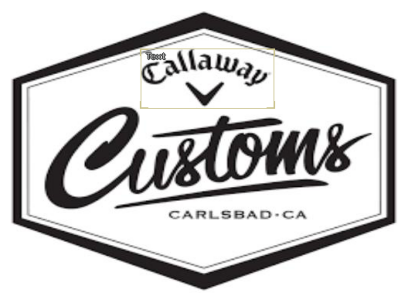

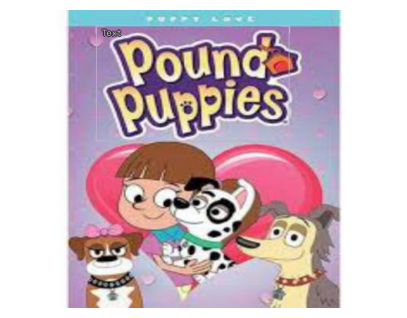

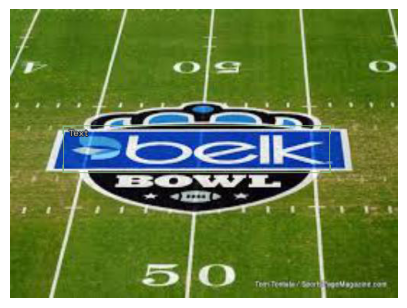

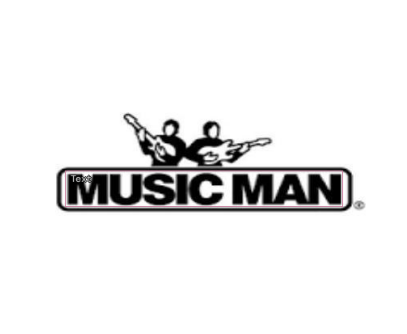

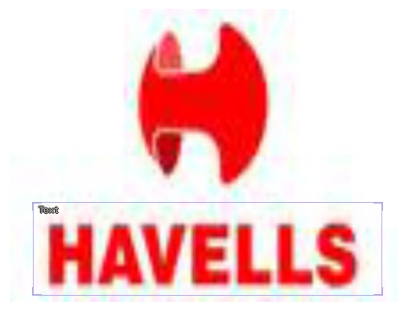

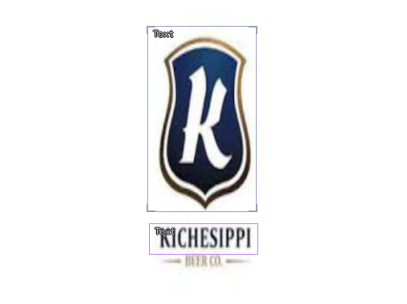

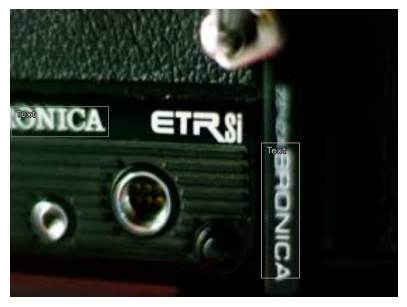

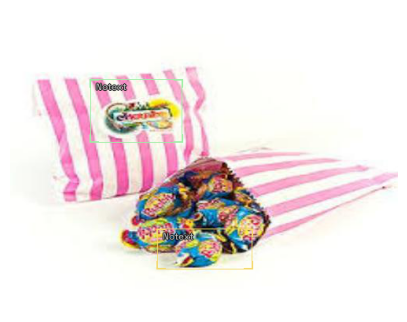

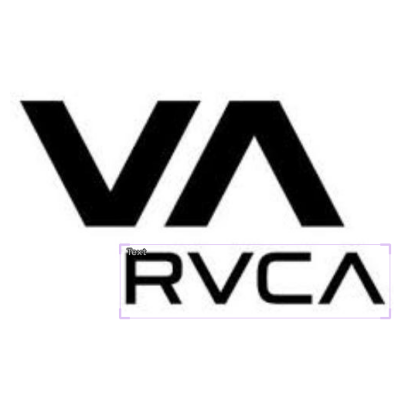

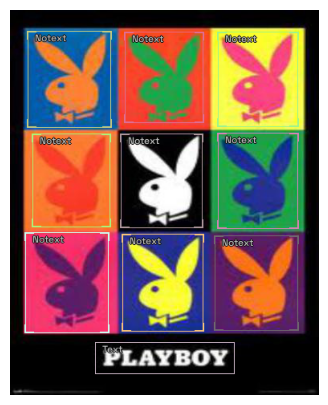

In [ ]:
for idx in range(0, 10):
  show_record(train_records[idx], display_label=True, figsize=(5, 5))

In [ ]:
train_records[0]

BaseRecord

common: 
	- Image size ImgSize(width=502, height=367)
	- Filepath: /content/Datasets/LogoDet-3K/Sports/Callaway/59.jpg
	- Img: None
	- Record ID: LogoDet-3K/Sports/Callaway/59.jpg
detection: 
	- Class Map: <ClassMap: {'background': 0, 'Text': 1, 'NoText': 2}>
	- Labels: [1]
	- BBoxes: [<BBox (xmin:169, ymin:51, xmax:341, ymax:128)>]

## Transforms and Dataloader

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

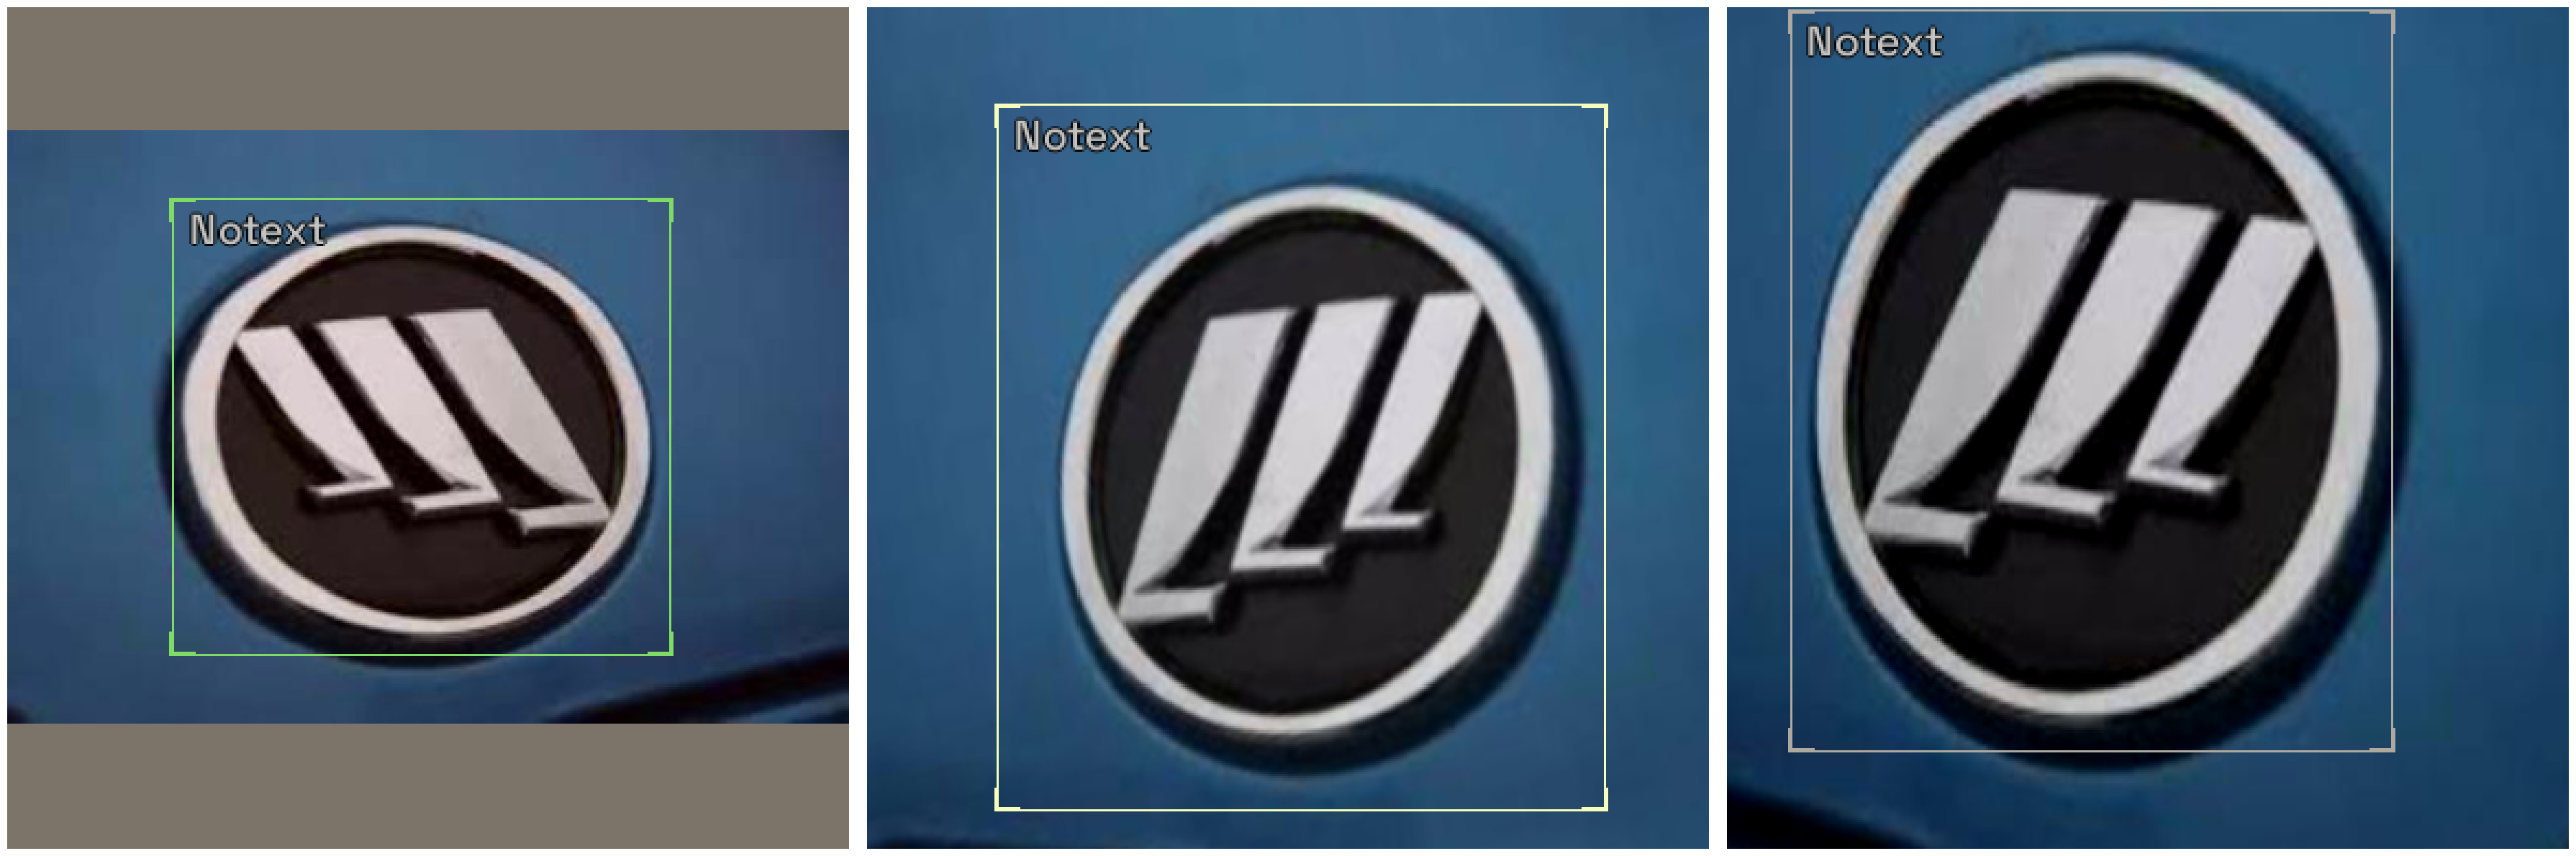

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[10000] for _ in range(3)]
show_samples(samples, ncols=3)

## Get the model

In [ ]:
extra_args = {}
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args)

### Initialize the dataloaders and start training

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=64, num_workers=2, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=64, num_workers=2, shuffle=False)
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=9.120108734350652e-05)

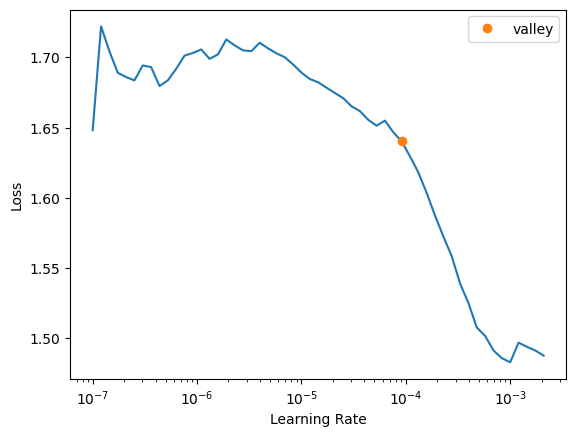

In [ ]:
## find the learning rate
learn.lr_find()

In [ ]:
keep_path = learn.path
learn.path = Path('/content/models/checkpoints') ##save checkpoints in this path
os.makedirs('/content/models/checkpoints', exist_ok=True)

In [ ]:
## Freeze the other layers and train the first layer
learn.freeze()
learn.fit_one_cycle(1, slice(1e-5, 1e-4), cbs=[CSVLogger(), SaveModelCallback(every_epoch=2), EarlyStoppingCallback(patience=3), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.001, patience=5)])

epoch,train_loss,valid_loss,COCOMetric,time
0,0.741335,0.799312,0.121842,20:19


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (112579839 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette i

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=4.365158383734524e-05)

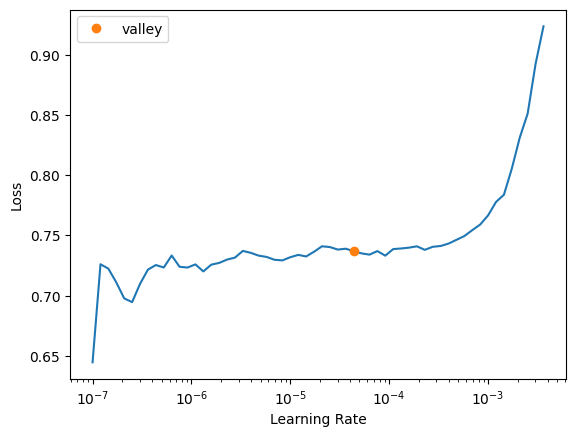

In [ ]:
## Unfreeze the layers after the step above and find the learning rate using lr find
learn.unfreeze()
learn.lr_find()

In [ ]:
## Train for some more epochs after putting the new learning rate found
learn.fit_one_cycle(5, slice(1e-5, 1e-4), cbs=[CSVLogger(), SaveModelCallback(every_epoch=2), EarlyStoppingCallback(patience=7), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.001, patience=4)])

epoch,train_loss,valid_loss,COCOMetric,time
0,0.657057,0.724609,0.178659,21:51
1,0.608892,0.648564,0.222450,21:36
2,0.572919,0.619397,0.250340,21:37
3,0.528299,0.593647,0.263333,21:34


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (112579839 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:976: UserWarning: Palette i

epoch,train_loss,valid_loss,COCOMetric,time
0,0.657057,0.724609,0.178659,21:51
1,0.608892,0.648564,0.222450,21:36
2,0.572919,0.619397,0.250340,21:37
3,0.528299,0.593647,0.263333,21:34
4,0.520074,0.588439,0.269837,21:29


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2921: DecompressionBombWarning: Image size (112579839 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
## Check the validation scores
learn.validate()

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


(#2) [0.5884391069412231,0.26983714155351823]

## Save the checkpoints

In [ ]:
from icevision.models.checkpoint import save_icevision_checkpoint

In [ ]:
checkpoint_path = '/content/models/checkpoints/logo-retinanet-checkpoint-52k_384_50_learn.pth'
img_size = 384
save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  parser.class_map.get_classes(), 
                        img_size=img_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

## Check the results

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


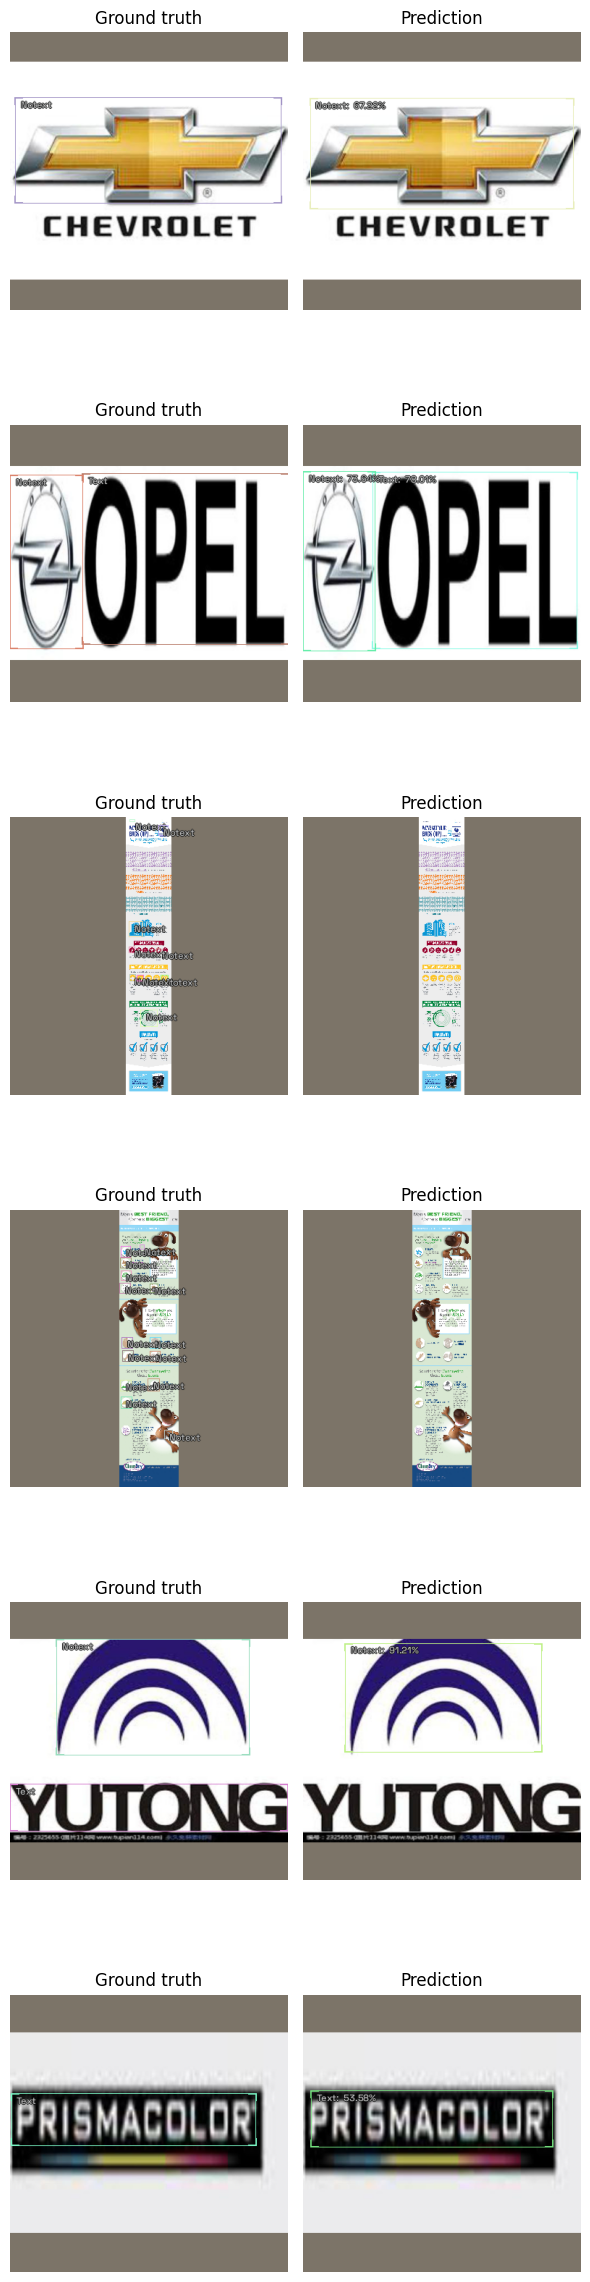

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

## Infer using a pretrained model

In [ ]:
## Download the pretrained model weights
%cd /content/models/checkpoints/
!gdown 1J4hG6MRY-k_72wtz6DlYBTiHvAFLbHKP
%cd /content/

/content/models/checkpoints
/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Downloading...
From: https://drive.google.com/uc?id=1J4hG6MRY-k_72wtz6DlYBTiHvAFLbHKP
To: /content/models/checkpoints/logo-retinanet-checkpoint-52k_384_50.pth
100% 146M/146M [00:00<00:00, 182MB/s]
/content


In [ ]:
from icevision.models.checkpoint import model_from_checkpoint

def get_logo_model(checkpoint_path):
    checkpoint_and_model = model_from_checkpoint(checkpoint_path)
    model_type = checkpoint_and_model["model_type"]
    backbone = checkpoint_and_model["backbone"]
    class_map = checkpoint_and_model["class_map"]
    img_size = checkpoint_and_model["img_size"]
    model_type, backbone, class_map, img_size
    model = checkpoint_and_model["model"]
    return class_map, model, model_type

class_map, model, model_type = get_logo_model("/content/models/checkpoints/logo-retinanet-checkpoint-52k_384_50.pth")

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/2692 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


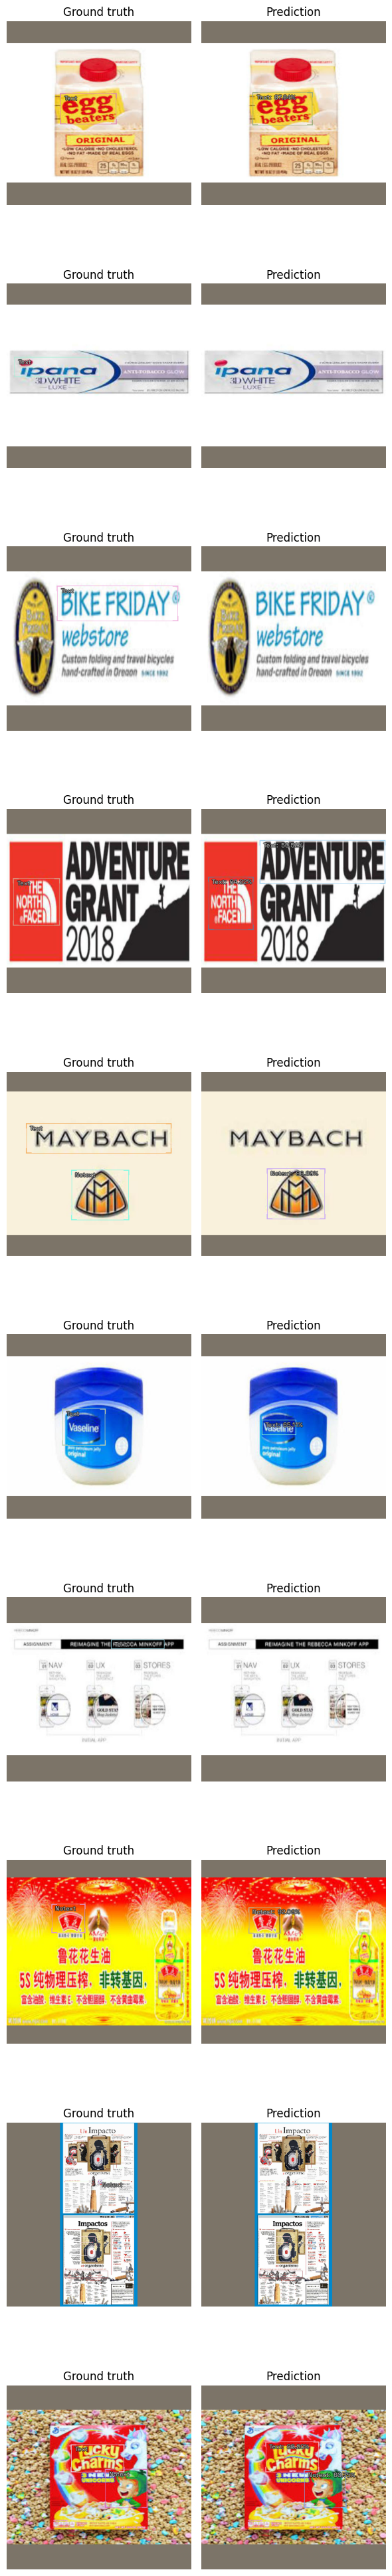

In [ ]:
show_preds(preds=preds[100:110])